In [1]:
%pip install torchattacks

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/sw/arch/RHEL8/EB_production/2022/software/Python/3.10.4-GCCcore-11.3.0/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install gpytorch

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 MB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 KB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 15.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 14.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 8.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 MB 15.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 34.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 13.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import sys
import os
sys.path.append('/home/ztzifa/effective_dimensionality')
print(sys.path)

import argparse
import torch
import torch.nn as nn
import torchvision
import torchattacks
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np

from hess import data
import hess.nets as models
from model import make_cnn, accuracy
from hess_vec_prod import min_max_hessian_eigs


def eff_dim(x, s = 1.):
    x = x[x!=1.] #remove eigenvalues that didnt converge from the lanczos computation to make things less noisy
    return np.sum(x / (x + s))

CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(f"CUDA: {CUDA}")

['/gpfs/home6/ztzifa', '', '/sw/arch/RHEL8/EB_production/2022/software/matplotlib/3.5.2-foss-2022a/lib/python3.10/site-packages', '/sw/arch/RHEL8/EB_production/2022/software/Tkinter/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages', '/sw/arch/RHEL8/EB_production/2022/software/SciPy-bundle/2022.05-foss-2022a/lib/python3.10/site-packages', '/sw/arch/RHEL8/EB_production/2022/software/torchvision/0.13.1-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages', '/sw/arch/RHEL8/EB_production/2022/software/Pillow-SIMD/9.2.0-GCCcore-11.3.0/lib/python3.10/site-packages', '/sw/arch/RHEL8/EB_production/2022/software/PyTorch/1.12.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages', '/sw/arch/RHEL8/EB_production/2022/software/expecttest/0.1.3-GCCcore-11.3.0/lib/python3.10/site-packages', '/sw/arch/RHEL8/EB_production/2022/software/Pillow/9.1.1-GCCcore-11.3.0/lib/python3.10/site-packages', '/sw/arch/RHEL8/EB_production/2022/software/PyYAML/6.0-GCCcore-11.3.0/lib/python3.10/site-packages', '/sw/arch

In [ ]:
#torch.backends.cudnn.benchmark = True
#torch.manual_seed(args.seed)
#torch.cuda.manual_seed(args.seed)

In [2]:
BATCH_SIZE = 128
TRAINING_ITERS = 3*10**5

NUM_CLASSES = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def evaluate_accuracy(model, dataloader, topk=(1,), log=False):
    all_output = None
    all_true_labels = None
    first = True

    model.eval()
    for x, y in dataloader:
      inputs = x.to(device)

      logits = model(inputs)
      model.zero_grad()

      if first: # handle first batch differently
          all_output = logits.detach().cpu()
          all_true_labels = y.detach()
          first = False
      else:
          all_output = torch.concat([all_output, logits.detach().cpu()], axis=0)
          all_true_labels = torch.concat([all_true_labels, y], axis=0)

          if log and all_true_labels.shape[0] % 500 == 0:
              print(f"{all_true_labels.shape[0]}, ", end='')

    if log:
      print("fin!")
    model.train()
    return accuracy(all_output, all_true_labels, topk=topk)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
results = {}
min_max_fn = min_max_hessian_eigs
kwargs = {"nsteps": 100} # default is 100
WHICH_DATASET = 'test'

for FILTER_SIZE in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 20, 24, 32, 40, 48, 64]:

    print(f"Filter size: {FILTER_SIZE}")
    model = make_cnn(FILTER_SIZE).to(device)
    criterion = nn.CrossEntropyLoss()

    loaded = torch.load(f"./checkpoints/{FILTER_SIZE}/cnn_{TRAINING_ITERS}.pth")
    cur_iter_, model_state_dict, optimizer_state_dict = loaded['cur_iter'], loaded['model_state_dict'], loaded['optimizer_state_dict']
    
    model.load_state_dict(model_state_dict); model.eval()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer.load_state_dict(optimizer_state_dict)
    
    train_acc = evaluate_accuracy(model, trainloader, (1,))[0][1]
    #print(f" - Accuracy: (train) {train_acc:.2f}%")
    eval_acc = evaluate_accuracy(model, testloader, (1,))[0][1]
    #print(f" - Accuracy: (eval) {eval_acc:.2f}%")

    max_eval, min_eval, hvps, pos_evals, neg_evals, pos_bases = min_max_fn(
        model, trainloader if WHICH_DATASET == 'train' else testloader, criterion, use_cuda=True, verbose=False, **kwargs
    )
    
    if neg_evals is not None:
        neg_evals = neg_evals.cpu().numpy()
    
    eigs = pos_evals.cpu().numpy()
    effective_dimension = eff_dim(eigs)

    results[FILTER_SIZE] = {
        'train': train_acc,
        'eval': eval_acc,
        'eff_dim': effective_dimension,
        'train_or_test': WHICH_DATASET
    }
    print(results[FILTER_SIZE])
    torch.save(results, f'./{WHICH_DATASET}_eff_dims.pth')

Filter size: 1


FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/1/cnn_300000.pth'

#### Eval

In [4]:
results = torch.load('train_eff_dims.pth')
results_test = torch.load('test_eff_dims.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'train_eff_dims.pth'

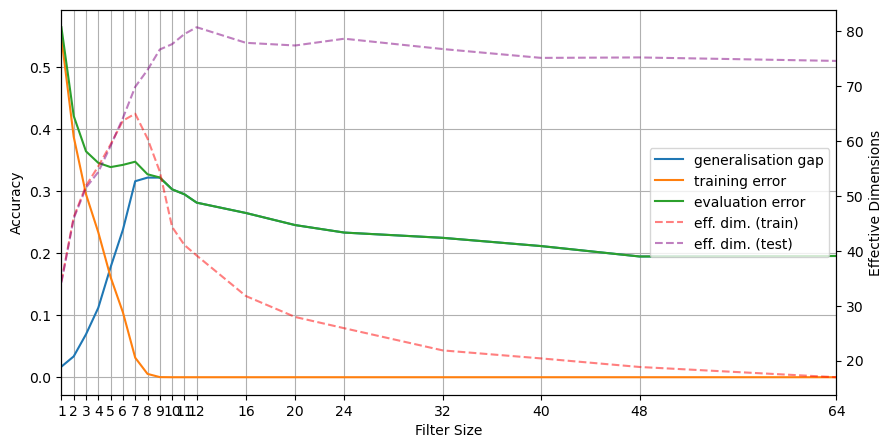

In [8]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(10, 5))
plt.grid(True)
ax2 = ax.twinx()

ax.set_xlabel('Filter Size')
ax.set_ylabel('Accuracy')
ax2.set_ylabel('Effective Dimensions')

xs = [int(x) for x in results.keys()]
ys = [(x['train'] - x['eval'])/100 for x in results.values()]

plt.xticks(xs)
ax.plot(xs, ys, label="generalisation gap")

ys = [1- x['train']/100 for x in results.values()]
ax.plot(xs, ys, label="training error")
ys = [1- x['eval']/100 for x in results.values()]
ax.plot(xs, ys, label="evaluation error")

ys = [x['eff_dim'] for x in results.values()]
ax2.plot(xs, ys, label="eff. dim. (train)", color='red', alpha=0.5, linestyle='dashed')
ys = [x['eff_dim'] for x in results_test.values()]
ax2.plot(xs, ys, label="eff. dim. (test)", color='purple', alpha=0.5, linestyle='dashed')

plt.xlim(min(xs), max(xs))
#plt.ylim(0, 0.6)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()

In [9]:
# Cell 1: Fixed MAIR setup with correct paths
import sys
import os

# Use the correct absolute path to your MAIR directory
mair_path = '/home/ztzifa/effective_dimensionality/MAIR'
project_path = '/home/ztzifa/effective_dimensionality'

# Add both paths
if mair_path not in sys.path:
    sys.path.insert(0, mair_path)
if project_path not in sys.path:
    sys.path.insert(0, project_path)

print("Python path updated:")
for i, path in enumerate(sys.path[:6]):
    print(f"  {i}: {path}")

# Check if directories exist
print(f"\nChecking paths:")
print(f"MAIR path exists: {os.path.exists(mair_path)} - {mair_path}")
print(f"Project path exists: {os.path.exists(project_path)} - {project_path}")

if os.path.exists(mair_path):
    mair_contents = os.listdir(mair_path)
    print(f"MAIR directory contents: {mair_contents}")
    
    mair_package_path = os.path.join(mair_path, 'mair')
    print(f"MAIR package path exists: {os.path.exists(mair_package_path)} - {mair_package_path}")


print("\nTrying to import mair...")
import mair
print("✓ Base mair module imported!")

from mair.defenses import Standard, AT, TRADES, MART
print("✓ Defense modules imported!")

from mair.utils.models import load_model
print("✓ Model utilities imported!")

# Now try your project functions
from hess_vec_prod import min_max_hessian_eigs
print("✓ Hessian functions imported!")

from AT_replication_complete import create_model_and_config, setup_mnist_data, setup_cifar10_data
print("✓ AT functions imported successfully!")

print("✓ All modules successfully imported!")
    

Python path updated:
  0: /home/ztzifa/effective_dimensionality/MAIR
  1: /gpfs/home6/ztzifa/MAIR
  2: /gpfs/home6/ztzifa
  3: 
  4: /sw/arch/RHEL8/EB_production/2022/software/matplotlib/3.5.2-foss-2022a/lib/python3.10/site-packages
  5: /sw/arch/RHEL8/EB_production/2022/software/Tkinter/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages

Checking paths:
MAIR path exists: True - /home/ztzifa/effective_dimensionality/MAIR
Project path exists: True - /home/ztzifa/effective_dimensionality
MAIR directory contents: ['setup.py', 'LICENSE', 'demos', 'images', 'README.md', '.gitignore', 'mair.egg-info', '.git', 'mair']
MAIR package path exists: True - /home/ztzifa/effective_dimensionality/MAIR/mair

Trying to import mair...
✓ Base mair module imported!
✓ Defense modules imported!
✓ Model utilities imported!
✓ Hessian functions imported!
✓ AT functions imported successfully!
✓ All modules successfully imported!


In [16]:
# Cell 3: Fixed analysis function with absolute paths
import torch
import torch.nn as nn
import glob
import os

def eff_dim(x, s=1.):
    x = x[x!=1.]
    return np.sum(x / (x + s))

def analyze_lenet_checkpoints(defense_method="AT", max_checkpoints=10):
    """Analyze LeNet checkpoints using effective dimensionality"""
    
    print(f"Analyzing LeNet {defense_method}")
    
    # Use your existing functions
    model, config = create_model_and_config("LeNet")
    train_loader, test_loader, mean, std = setup_mnist_data(batch_size=128)
    
    # Use absolute path to your models directory
    models_base_path = '/home/ztzifa/effective_dimensionality/models'
    checkpoint_dir = f"{models_base_path}/LeNet_{defense_method}/epoch_iter"
    
    print(f"Checking checkpoint directory: {checkpoint_dir}")
    print(f"Directory exists: {os.path.exists(checkpoint_dir)}")
    
    if not os.path.exists(checkpoint_dir):
        checkpoint_dir = f"{models_base_path}/LeNet_{defense_method}"
        print(f"Trying main directory: {checkpoint_dir}")
        print(f"Main directory exists: {os.path.exists(checkpoint_dir)}")
    
    if os.path.exists(checkpoint_dir):
        all_files = os.listdir(checkpoint_dir)
        print(f"Files in directory: {all_files}")
        
        checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, "*.pth")))
        print(f"All .pth files: {[os.path.basename(f) for f in checkpoint_files]}")
        
        # Filter out non-checkpoint files
        checkpoint_files = [f for f in checkpoint_files if not any(x in os.path.basename(f) 
                           for x in ['best', 'last', 'init'])]
        
        print(f"Filtered checkpoint files: {[os.path.basename(f) for f in checkpoint_files]}")
    else:
        print("Checkpoint directory not found!")
        return {}
    
    if len(checkpoint_files) > max_checkpoints:
        step = len(checkpoint_files) // max_checkpoints
        checkpoint_files = checkpoint_files[::step]
        print(f"Sampling every {step}th checkpoint")
    
    print(f"Processing {len(checkpoint_files)} checkpoints")
    
    if len(checkpoint_files) == 0:
        print("No checkpoints found!")
        return {}
    
    results = {}
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for i, checkpoint_path in enumerate(checkpoint_files):
        print(f"\nProcessing checkpoint {i+1}/{len(checkpoint_files)}: {os.path.basename(checkpoint_path)}")
        
        try:
            # Create fresh model
            model, config = create_model_and_config("LeNet")
            model = model.to(device)
            
            # Load checkpoint
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            
            if 'rmodel_state_dict' in checkpoint:
                rmodel_state = checkpoint['rmodel_state_dict']
                base_model_state = {}
                for key, value in rmodel_state.items():
                    if key.startswith('model.'):
                        base_key = key[6:]
                        base_model_state[base_key] = value
                model.load_state_dict(base_model_state)
            elif 'rmodel' in checkpoint:
                # Handle direct 'rmodel' key - extract model weights and strip 'model.' prefix
                rmodel_state = checkpoint['rmodel']
                base_model_state = {}
                for key, value in rmodel_state.items():
                    if key.startswith('model.'):
                        base_key = key[6:]  # Remove 'model.' prefix
                        base_model_state[base_key] = value
                model.load_state_dict(base_model_state)
            elif 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
            else:
                model.load_state_dict(checkpoint)
                        
            model.eval()
                        
            # Compute effective dimensionality
            max_eval, min_eval, hvps, pos_evals, neg_evals, pos_bases = min_max_hessian_eigs(
                model, train_loader, criterion, use_cuda=(device.type == 'cuda'), 
                verbose=False, nsteps=50
            )
            
            eigs = pos_evals.cpu().numpy()
            effective_dimension = eff_dim(eigs)
            
            results[i] = {
                'checkpoint': os.path.basename(checkpoint_path),
                'effective_dimensionality': effective_dimension,
                'max_eigenvalue': float(max_eval),
                'num_eigenvalues': len(eigs)
            }
            
            print(f"  Effective Dimensionality: {effective_dimension:.4f}")
            
        except Exception as e:
            print(f"  Error: {e}")
            continue
    
    # Save results with absolute path
    results_path = f'/home/ztzifa/effective_dimensionality/LeNet_{defense_method}_effective_dim_trajectory.pth'
    torch.save(results, results_path)
    print(f"\nResults saved to: {results_path}")
    
    return results

# Run the analysis
results = analyze_lenet_checkpoints("AT")

Analyzing LeNet AT
Checking checkpoint directory: /home/ztzifa/effective_dimensionality/models/LeNet_AT/epoch_iter
Directory exists: True
Files in directory: ['00013_00000.pth', '00098_00000.pth', '00056_00000.pth', '00092_00000.pth', '00063_00000.pth', '00025_00000.pth', '00062_00000.pth', '00024_00000.pth', '00043_00000.pth', '00049_00000.pth', '00022_00000.pth', '00089_00000.pth', '00076_00000.pth', '00064_00000.pth', '00080_00000.pth', '00060_00000.pth', '00068_00000.pth', '00020_00000.pth', '00007_00000.pth', '00055_00000.pth', '00036_00000.pth', '00042_00000.pth', '00017_00000.pth', '00078_00000.pth', '00050_00000.pth', '00057_00000.pth', '00039_00000.pth', '00085_00000.pth', '00087_00000.pth', '00012_00000.pth', '00065_00000.pth', '00100_00000.pth', '00054_00000.pth', '00053_00000.pth', '00058_00000.pth', '00035_00000.pth', '00073_00000.pth', '00034_00000.pth', '00026_00000.pth', '00091_00000.pth', '00029_00000.pth', '00014_00000.pth', '00051_00000.pth', '00095_00000.pth', '0008

: 

: 

: 